In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\hp\appdata\local\temp\pip-req-build-g0dxxbga
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 320.0 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.0 kB 259.2 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 270.3 kB/s eta 0:00:00
     ---------------------------------------- 

  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-g0dxxbga'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 4.44.0 requires urllib3~=2.0, but you have urllib3 1.26.20 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch  # PyTorch to convert values ino torch tensors.
from chronos import ChronosPipeline

d:\Anaconda\envs\sanka_vir\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df =  pd.read_csv("../data/data.csv")
df =  df.sort_index(ascending = False)
df = df.reset_index(drop = True)
df.head()

,Date,Exchange Rate
0,5/7/2010,136459.7395
1,5/11/2010,136684.5647
2,5/12/2010,139577.2499
3,5/13/2010,140790.1394
4,5/14/2010,140514.5200


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Exchange Rate
0,2010-05-07,136459.7395
1,2010-05-11,136684.5647
2,2010-05-12,139577.2499
3,2010-05-13,140790.1394
4,2010-05-14,140514.5200


In [5]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))
    return x/mean

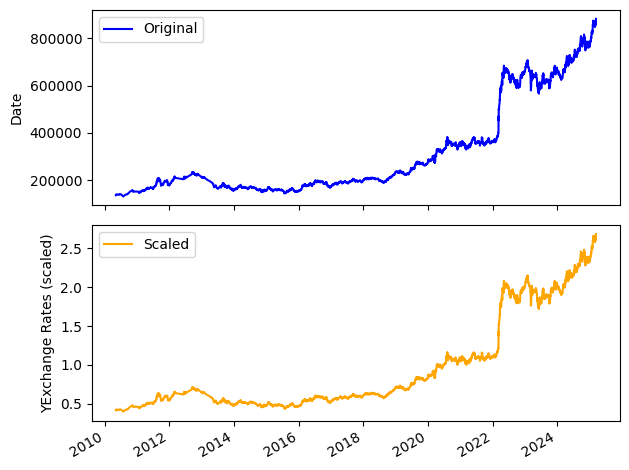

In [8]:
y = df['Exchange Rate'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['Date'], y, color='blue', label='Original')
ax1.set_ylabel('Date')
ax1.legend()

ax2.plot(df['Date'], y_scaled, color='orange', label='Scaled')
ax2.set_ylabel('YExchange Rates (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()


In [9]:
# Chronos Pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# Forecasting steps
horizon = 60

series_tensor = torch.tensor(df["Exchange Rate"].values)

# predictions for the horizon
forecast = pipeline.predict([series_tensor], horizon)

DatetimeIndex(['2025-03-15', '2025-03-16', '2025-03-17', '2025-03-18',
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-22',
               '2025-03-23', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28', '2025-03-29', '2025-03-30',
               '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03',
               '2025-04-04', '2025-04-05', '2025-04-06', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-12', '2025-04-13', '2025-04-14', '2025-04-15',
               '2025-04-16', '2025-04-17', '2025-04-18', '2025-04-19',
               '2025-04-20', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25', '2025-04-26', '2025-04-27',
               '2025-04-28', '2025-04-29', '2025-04-30', '2025-05-01',
               '2025-05-02', '2025-05-03', '2025-05-04', '2025-05-05',
               '2025-05-06', '2025-05-07', '2025-05-08', '2025-05-09',
      

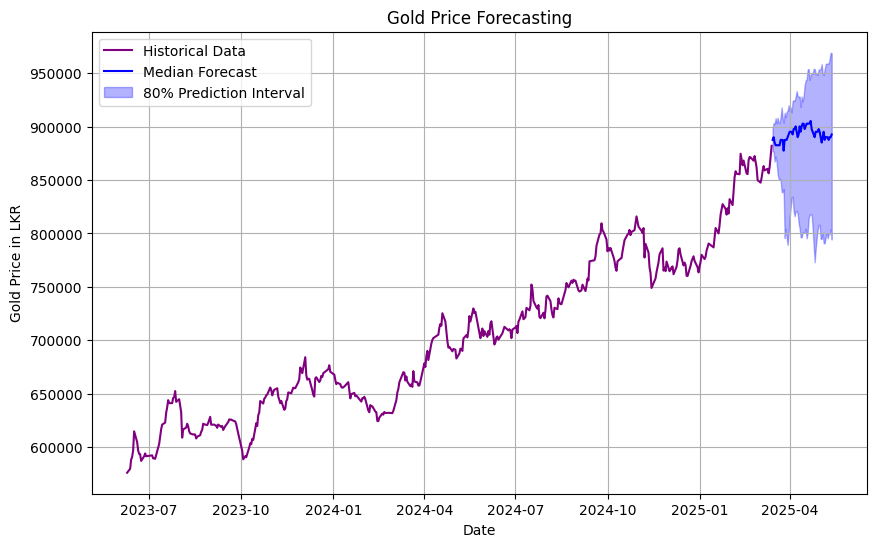

In [11]:
forecast_index = pd.date_range(df["Date"].iloc[-1], periods=61, freq='D')[1:]  # Adjust to skip the first date
print(forecast_index)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][2700:], df["Exchange Rate"][2700:], color="purple", label="Historical Data")
plt.plot(forecast_index, median, color="blue", label="Median Forecast")
plt.fill_between(forecast_index, low, high, color="blue", alpha=0.3, label="80% Prediction Interval")
plt.legend()
plt.grid()
plt.xlabel("Date")
plt.ylabel("Gold Price in LKR")
plt.title("Gold Price Forecasting")
plt.show()